# Bird Species Transfer Learning and Fine-tuning

This notebook uses the VGG16 pre-trained model from TensorFlow and fine-tunes it to classify bird species with the best possible performance.

## Imports and Data Loading

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import data as tf_data
import tensorflow.keras as keras
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define path to data directory
data_dir = os.path.join('drive', 'MyDrive', 'ConcordiaBootcamp', 'Data', 'birds')

In [4]:
# Define directories
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
pred_dir = os.path.join(data_dir, 'images to predict')

## EDA

In [5]:
# Get subfolders
subfolders = [d.name for d in Path(data_dir).iterdir() if d.is_dir()]
subfolders

['images to predict', 'test', 'train', 'valid']

In [7]:
# Get total number of images in dataset
complete_list = list(Path(data_dir).glob('*/*/*.jpg'))
nb_images = len(complete_list)
nb_images

3408

In [8]:
# Get size of training set
train_img_paths = list(Path(train_dir).glob('*/*.jpg'))
train_size = len(train_img_paths)
train_size

3208

In [9]:
# Get size of validation set
val_img_paths = list(Path(val_dir).glob('*/*.jpg'))
val_size = len(val_img_paths)
val_size

100

In [10]:
# Get size of test set
test_img_paths = list(Path(test_dir).glob('*/*.jpg'))
test_size = len(test_img_paths)
test_size

100

In [11]:
# Get number of images to predict
pred_img_paths = list(Path(pred_dir).glob('*.jpg'))
pred_size = len(pred_img_paths)
pred_size

6

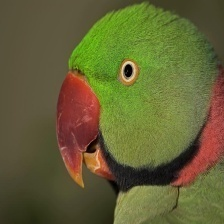

In [12]:
# Load one image from dataset at random
np.random.seed(42)
random_img_path = np.random.choice(complete_list)
random_img = Image.open(random_img_path)
display(random_img)

In [13]:
# Get size of that image
random_img.size

(224, 224)

## Data Preprocessing

In [14]:
# Define image size
img_height = 150
img_width = 150

In [15]:
# Preprocess the train set
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=0.2,
    horizontal_flip=True)
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

Found 3208 images belonging to 20 classes.


In [16]:
# Preprocess the validation set
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_set = valid_datagen.flow_from_directory(val_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)

Found 100 images belonging to 20 classes.


In [17]:
# Preprocess the test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)

Found 100 images belonging to 20 classes.


## Data Modeling

### Load pre-trained model

In [18]:
# Load base model with the top classification layer
initial_model = VGG16(weights="imagenet")
initial_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

### Test some images

In [19]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path, size):
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

#### Compare labels from base model and dataset

In [20]:
# Get 5 images at random
np.random.seed(42)
rand_img_paths = np.random.choice(complete_list, 5, replace=False)

preds = []

for img_path in rand_img_paths:
  image = Image.open(img_path)
  img = load_and_preprocess_image(img_path, (224, 224))
  actual = os.path.basename(os.path.dirname(img_path))
  y_pred = initial_model.predict(img)
  pred_id, pred_label, confidence = decode_predictions(y_pred, top=1)[0][0]

  preds.append({
      'image': image,
      'predicted': f'{pred_label} ({confidence:.2%})',
      'actual': actual
  })

val_df = pd.DataFrame(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


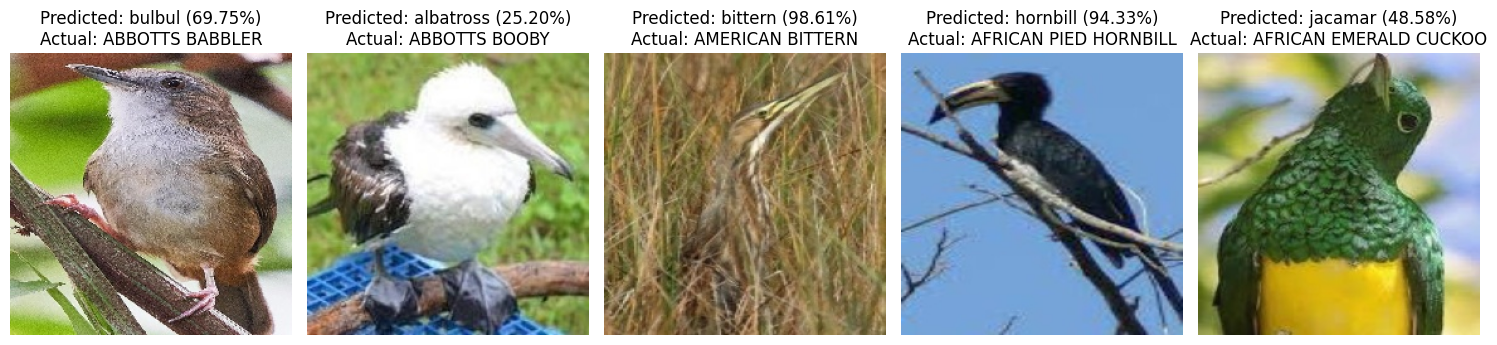

In [21]:
# Display images and labels
images = val_df['image'].to_list()
actual = val_df['actual'].to_list()
predicted = val_df['predicted'].to_list()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

for i in range(5):
    title = f'Predicted: {predicted[i]}\nActual: {actual[i]}'
    axes[i].imshow(images[i])
    axes[i].title.set_text(title)
    axes[i].axis('off')

fig.tight_layout()
plt.show()

The third and fourth predictions are correct.

#### Get labels of images to predict

In [22]:
def display_images(df: pd.DataFrame) -> None:
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
  images = df['image'].to_list()
  base_pred = df['base_pred'].to_list()
  new_pred = df['new_pred'].to_list() if 'new_pred' in df.columns else None

  for i, ax in enumerate(axes.flatten()):
    new_pred_label = '\nNew model: ' + new_pred[i] if new_pred else ''
    title = f'Base model: {base_pred[i]}{new_pred_label}'
    ax.imshow(images[i])
    ax.title.set_text(title)
    ax.axis('off')

  fig.tight_layout()
  plt.show()

In [24]:
# Create dataframe with images to predict
pred_img_paths = sorted(pred_img_paths)
to_predict = []

for img_path in pred_img_paths:
  image = Image.open(img_path)
  img = load_and_preprocess_image(img_path, (224, 224))
  yhat = initial_model.predict(img)
  pred_id, pred_label, confidence = decode_predictions(yhat, top=1)[0][0]

  to_predict.append({
      'img_path': img_path,
      'image': image,
      'base_pred': f'{pred_label} ({confidence:.2%})',
  })
to_predict_df = pd.DataFrame(to_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


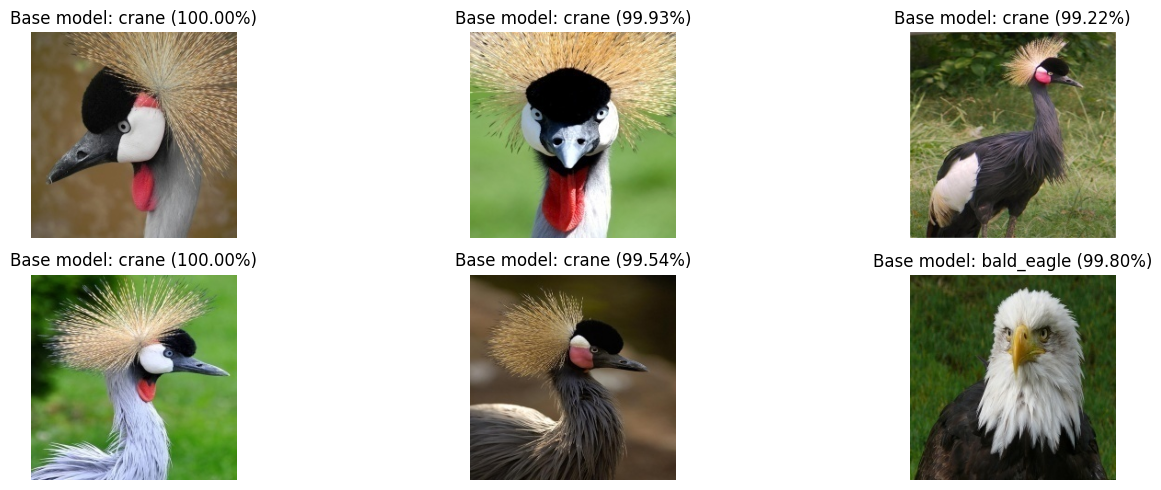

In [25]:
# Display images
display_images(to_predict_df)

### Fine-tune model

In [26]:
# Build model without the original classification layer
base_model = VGG16(
    weights="imagenet",
    input_shape=(img_width, img_height, 3),
    include_top=False,
)
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Freeze the base_model
base_model.trainable = False

In [28]:
# Add additional layers
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x) # regularization
outputs = keras.layers.Dense(20, activation='softmax')(x) # classification layer
model = keras.Model(inputs=base_model.input, outputs=outputs)
model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv1 (Conv2D)               │ (None, 150, 150, 64)         │         1,792 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv2 (Conv2D)               │ (None, 150, 150, 64)         │        36,928 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_pool (MaxPooling2D)          │ (None, 75, 75, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv1 (Conv2D)               │ (None, 75, 75, 128)          │        73,856 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv2 (Conv2D)               │ (None, 75, 75, 128)          │       147,584 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_pool (MaxPooling2D)          │ (None, 37, 37, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv1 (Conv2D)               │ (None, 37, 37, 256)          │       295,168 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv2 (Conv2D)               │ (None, 37, 37, 256)          │       590,080 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv3 (Conv2D)               │ (None, 37, 37, 256)          │       590,080 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_pool (MaxPooling2D)          │ (None, 18, 18, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv1 (Conv2D)               │ (None, 18, 18, 512)          │     1,180,160 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv2 (Conv2D)               │ (None, 18, 18, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv3 (Conv2D)               │ (None, 18, 18, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_pool (MaxPooling2D)          │ (None, 9, 9, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv1 (Conv2D)               │ (None, 9, 9, 512)            │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv2 (Conv2D)               │ (None, 9, 9, 512)            │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv3 (Conv2D)               │ (None, 9, 9, 512)            │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_pool (MaxPooling2D)          │ (None, 4, 4, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)    

 Total params: 16,817,236 (64.15 MB)

 Trainable params: 2,102,548 (8.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Train the top layer

In [29]:
# Compile
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [30]:
# Fit
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_set, epochs=100, validation_data=valid_set, verbose=1, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 2552s 25s/step - accuracy: 0.1477 - loss: 2.8895 - val_accuracy: 0.5800 - val_loss: 1.8101
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 80s 281ms/step - accuracy: 0.4589 - loss: 1.9009 - val_accuracy: 0.7500 - val_loss: 1.1560
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.5872 - loss: 1.4140 - val_accuracy: 0.7600 - val_loss: 0.8530
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 282ms/step - accuracy: 0.6693 - loss: 1.1574 - val_accuracy: 0.8300 - val_loss: 0.7107
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.7119 - loss: 1.0041 - val_accuracy: 0.8400 - val_loss: 0.5861
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 315ms/step - accuracy: 0.7509 - loss: 0.8658 - val_accuracy: 0.8700 - val_loss: 0.5203
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.7745 - loss: 0.7858 - val_accuracy: 0.8700 - val_loss: 0.4767
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.8018 -

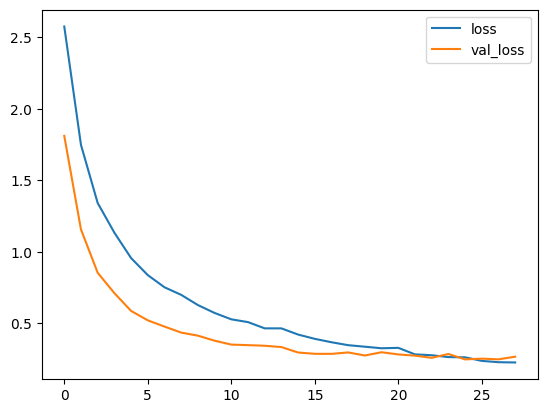

In [31]:
# Plot training vs. validation loss
metrics_top = pd.DataFrame(model.history.history)
metrics_top[['loss','val_loss']].plot();

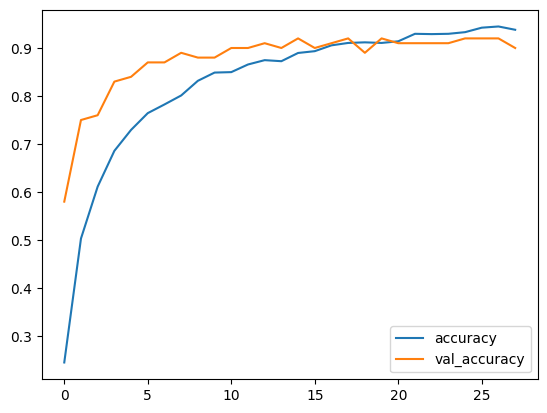

In [32]:
# Plot training vs. validation accuracy
metrics_top[['accuracy','val_accuracy']].plot();

#### Train all the layers


In [33]:
# Unfreeze the base model
base_model.trainable = True
model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv1 (Conv2D)               │ (None, 150, 150, 64)         │         1,792 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv2 (Conv2D)               │ (None, 150, 150, 64)         │        36,928 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_pool (MaxPooling2D)          │ (None, 75, 75, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv1 (Conv2D)               │ (None, 75, 75, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv2 (Conv2D)               │ (None, 75, 75, 128)          │       147,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_pool (MaxPooling2D)          │ (None, 37, 37, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv1 (Conv2D)               │ (None, 37, 37, 256)          │       295,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv2 (Conv2D)               │ (None, 37, 37, 256)          │       590,080 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv3 (Conv2D)               │ (None, 37, 37, 256)          │       590,080 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_pool (MaxPooling2D)          │ (None, 18, 18, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv1 (Conv2D)               │ (None, 18, 18, 512)          │     1,180,160 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv2 (Conv2D)               │ (None, 18, 18, 512)          │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv3 (Conv2D)               │ (None, 18, 18, 512)          │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_pool (MaxPooling2D)          │ (None, 9, 9, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv1 (Conv2D)               │ (None, 9, 9, 512)            │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv2 (Conv2D)               │ (None, 9, 9, 512)            │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv3 (Conv2D)               │ (None, 9, 9, 512)            │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_pool (MaxPooling2D)          │ (None, 4, 4, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)    

 Total params: 21,022,334 (80.19 MB)

 Trainable params: 16,817,236 (64.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,205,098 (16.04 MB)

In [34]:
# Compile
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Fit
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_set, epochs=100, validation_data=valid_set, verbose=1, callbacks=[early_stop])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 75s 478ms/step - accuracy: 0.9393 - loss: 0.1907 - val_accuracy: 0.9300 - val_loss: 0.1656
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 32s 318ms/step - accuracy: 0.9628 - loss: 0.1169 - val_accuracy: 0.9400 - val_loss: 0.2066
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 329ms/step - accuracy: 0.9601 - loss: 0.1179 - val_accuracy: 0.9500 - val_loss: 0.1480
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 34s 332ms/step - accuracy: 0.9711 - loss: 0.0876 - val_accuracy: 0.9700 - val_loss: 0.1128
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 327ms/step - accuracy: 0.9821 - loss: 0.0656 - val_accuracy: 0.9300 - val_loss: 0.2341
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - accuracy: 0.9815 - loss: 0.0651 - val_accuracy: 0.9700 - val_loss: 0.1225
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 323ms/step - accuracy: 0.9804 - loss: 0.0635 - val_accuracy: 0.9600 - val_loss: 0.1837


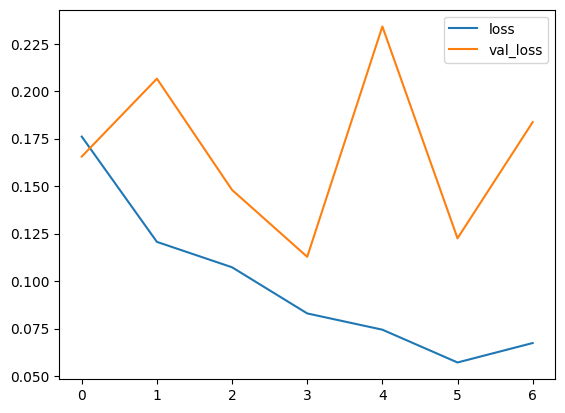

In [36]:
# Plot training vs. validation loss
metrics_all = pd.DataFrame(model.history.history)
metrics_all[['loss','val_loss']].plot();

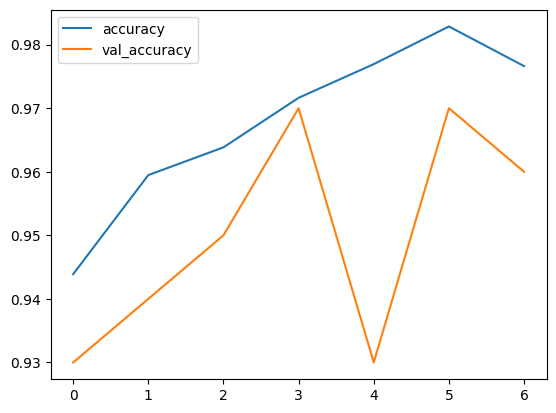

In [37]:
# Plot training vs. validation accuracy
metrics_all[['accuracy','val_accuracy']].plot();

In [40]:
# Save model
model_path = os.path.join('drive', 'MyDrive', 'ConcordiaBootcamp', 'Data', 'bird_classifier')
model.export(model_path)

Saved artifact at 'drive/MyDrive/ConcordiaBootcamp/Data/bird_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_23')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  137326081897680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081897872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081895376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081894224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081894800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081893456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081897104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081899984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081900368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137326081899408: TensorSpec(shape=(), dtype=

### Evaluate model on test set

In [39]:
# Build classification report
labels = list(test_set.class_indices.values())
target_names = list(test_set.class_indices.keys())

y_pred = model.predict(test_set)
test_set.reset()
y_true = []
for i in range(len(test_set)):
    y_true.extend(np.argmax(test_set[i][1], axis=1))

y_true = np.array(y_true)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 759ms/step
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.80      0.80      0.80         5
             ABBOTTS BOOBY       1.00      0.80      0.89         5
ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
     AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
    AFRICAN EMERALD CUCKOO       0.83      1.00      0.91         5
         AFRICAN FIREFINCH       1.00      0.80      0.89         5
    AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
     AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
       AFRICAN PYGMY GOOSE       0.83      1.00      0.91         5
                 ALBATROSS       1.00      1.00      1.00         5
            ALBERTS TOWHEE       1.00      1.00      1.00         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      0.80      0.89         5
   

The overall accuracy is 95%. The model did pretty good on all the classes, not so good on the abbotts babbler.

## Make predictions

In [41]:
# Add new model predictions to dataframe
def add_pred_label(row):
  img_path = row['img_path']
  img = load_and_preprocess_image(img_path, (img_width, img_height))
  y_pred = model.predict(img)
  pred_id = np.argmax(y_pred)
  confidence = np.max(y_pred)
  pred_label = list(test_set.class_indices.keys())[list(test_set.class_indices.values()).index(pred_id)]

  return f'{pred_label} ({confidence:.2%})'

to_predict_df['new_pred'] = to_predict_df.apply(add_pred_label, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


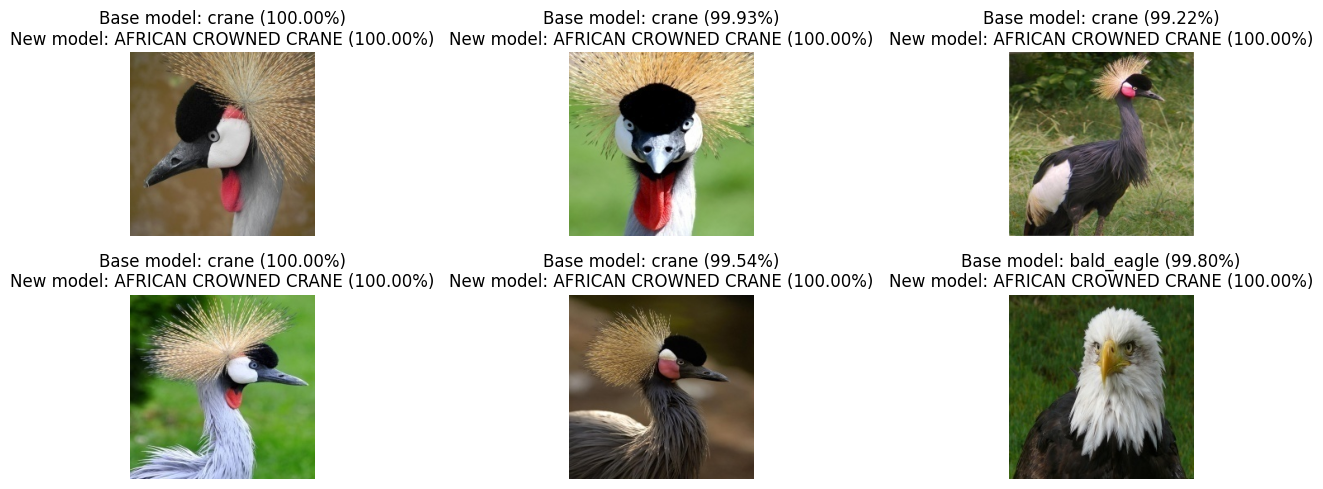

In [42]:
# Display images
display_images(to_predict_df)

The first 5 are correct except the last one, because the dataset didn't have bald eagle pictures.

## End